# SIMIND Introduction

In [1]:
import inspect
import matplotlib.pyplot as plt
import torch
from pytomography.io.SPECT import simind
from pytomography.projectors.SPECT import SPECTSystemMatrix
from pytomography.transforms.SPECT import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.algorithms import OSEM
from pytomography.likelihoods import PoissonLogLikelihood
import os

In [2]:
# CHANGE THIS TO WHERE YOU DOWNLOADED THE TUTORIAL DATA
PATH = '/disk1/pytomography_tutorial_data'
data_path = os.path.join(PATH, 'simind_tutorial', 'lu177_SYME_jaszak')

## 1. Opening Data

First we specify the save paths corresponding to the SIMIND header files for each of the three energy windows

In [3]:
photopeak_path = os.path.join(data_path,'tot_w4.h00')
lower_path = os.path.join(data_path, 'tot_w5.h00')
upper_path = os.path.join(data_path, 'tot_w6.h00')

PyTomography stores information such as voxel size, image dimensions, in metadata:
* `ObjectMeta`: Voxel size, image dimensions
* `ProjMeta` (for SPECT): detector angles, radial positions, detector pixel size/dimensions

In [4]:
object_meta, proj_meta = simind.get_metadata(photopeak_path)

In [5]:
object_meta

dr = (0.48000001907348633, 0.48000001907348633, 0.48000001907348633)
dx = 0.48000001907348633
dy = 0.48000001907348633
dz = 0.48000001907348633
pad_size = 27
padded_shape = (182, 182, 128)
recon_method = None
shape = (128, 128, 128)
units = counts

In [6]:
proj_meta

angles = tensor([  0.0000,   3.7500,   7.5000,  11.2500,  15.0000,  18.7500,  22.5000,
         26.2500,  30.0000,  33.7500,  37.5000,  41.2500,  45.0000,  48.7500,
         52.5000,  56.2500,  60.0000,  63.7500,  67.5000,  71.2500,  75.0000,
         78.7500,  82.5000,  86.2500,  90.0000,  93.7500,  97.5000, 101.2500,
        105.0000, 108.7500, 112.5000, 116.2500, 120.0000, 123.7500, 127.5000,
        131.2500, 135.0000, 138.7500, 142.5000, 146.2500, 150.0000, 153.7500,
        157.5000, 161.2500, 165.0000, 168.7500, 172.5000, 176.2500, 180.0000,
        183.7500, 187.5000, 191.2500, 195.0000, 198.7500, 202.5000, 206.2500,
        210.0000, 213.7500, 217.5000, 221.2500, 225.0000, 228.7500, 232.5000,
        236.2500, 240.0000, 243.7500, 247.5000, 251.2500, 255.0000, 258.7500,
        262.5000, 266.2500, 270.0000, 273.7500, 277.5000, 281.2500, 285.0000,
        288.7500, 292.5000, 296.2500, 300.0000, 303.7500, 307.5000, 311.2500,
        315.0000, 318.7500, 322.5000, 326.2500, 330.000

The actual projection data itself is loaded as follows:

In [7]:
photopeak = simind.get_projections(photopeak_path)
photopeak.shape

torch.Size([96, 128, 128])

This corresponds to 96 angles where each projection is 256x256. We can plot these projections as follows:

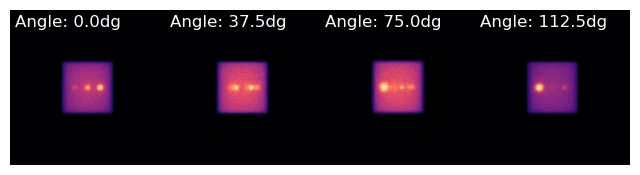

In [8]:
fig, ax = plt.subplots(1,4,figsize=(8,2.4), gridspec_kw={'wspace':0.0})
for i in range(4):
    ax[i].imshow(photopeak[10*i].cpu().T, cmap='magma')
    ax[i].axis('off')
    ax[i].text(0.03, 0.97, f'Angle: {10*proj_meta.angles[i]}dg', ha='left', va='top', color='white', transform=ax[i].transAxes, fontsize=12)

Raw SIMIND data has units of Counts / Second / MBq and represents the *expectation value* of the measured data in each detector bin. We can generate clinically realistic data by 
1. scaling by time and activity (converting to units of counts)
2. obtaining a Poisson realization

In [9]:
activity = 1000 # MBq 
time_per_proj = 15 # s
photopeak_realization = torch.poisson(photopeak * activity * time_per_proj)

The actual data is noisier:

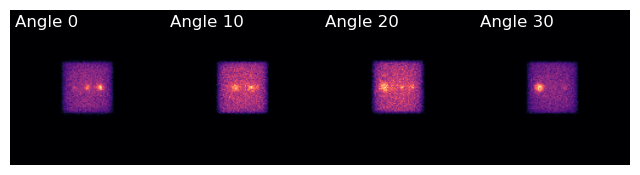

In [10]:
fig, ax = plt.subplots(1,4,figsize=(8,2.4), gridspec_kw={'wspace':0.0})
for i in range(4):
    ax[i].imshow(photopeak_realization[10*i].cpu().T, cmap='magma')
    ax[i].axis('off')
    ax[i].text(0.03, 0.97, f'Angle {10*i}', ha='left', va='top', color='white', transform=ax[i].transAxes, fontsize=12)

We can do similar things for the adjacent scatter windows:

In [11]:
lower = simind.get_projections(lower_path)
upper = simind.get_projections(upper_path)
lower_realization = torch.poisson(lower * activity * time_per_proj)
upper_realization = torch.poisson(upper * activity * time_per_proj)

These adjacent energy windows can be used to get an estimate for the scatter in the photopeak window via the triple energy window (TEW) technique:

In [12]:
ww_peak, ww_lower, ww_upper = [simind.get_energy_window_width(path) for path in [photopeak_path, lower_path, upper_path]]
scatter_estimate_TEW = simind.compute_EW_scatter(lower_realization, upper_realization , ww_lower, ww_upper, ww_peak)

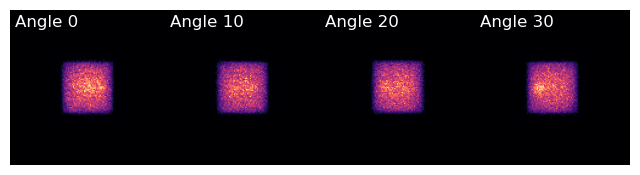

In [13]:
fig, ax = plt.subplots(1,4,figsize=(8,2.4), gridspec_kw={'wspace':0.0})
for i in range(4):
    ax[i].imshow(scatter_estimate_TEW[10*i].cpu().T, cmap='magma')
    ax[i].axis('off')
    ax[i].text(0.03, 0.97, f'Angle {10*i}', ha='left', va='top', color='white', transform=ax[i].transAxes, fontsize=12)

## 2. Creating the System Matrix

The SPECT system matrix depends on modeling (i) attenuation and (ii) collimator detector response (or point spread function)

### 2.1 Attenuation Modeling

For attenuation modeling we need the corresponding attenuation map. The SIMIND generated attenuation map can be loaded as follows:

In [14]:
path_amap = os.path.join(data_path, 'amap.hct')
amap = simind.get_attenuation_map(path_amap)

We can plot a 3D axial slice of this phantom (cylinder) as follows:

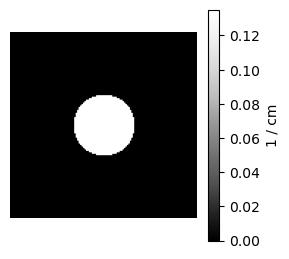

In [15]:
plt.figure(figsize=(3,3))
plt.imshow(amap[:,:,64].cpu().T, cmap='Greys_r')
plt.axis('off')
plt.colorbar(label='1 / cm')

From this attenuation map we build a `SPECTAttenuationTransform`, which will eventually be used in creating the system matrix

In [16]:
att_transform = SPECTAttenuationTransform(amap)

### 2.2 Collimator Detector Response (or Point Spread Function) Modeling

A perfect SPECT detector would only allow photons travelling perpendicular to the collimator holes to be detected: in practice this is not the case. The angle at which photons can enter depends on the collimator/scintillator parameters. We can get the metadata from the header as follows:

* The information gives the function/parameters for the point spread function, which depends on the distance between the source/detector $r$

In [17]:
psf_meta = simind.get_psfmeta_from_header(photopeak_path)
# Below is optional to print details about psf_meta
sigma_fit_func_code = inspect.getsource(psf_meta.sigma_fit)
print(psf_meta)
print(sigma_fit_func_code)

kernel_dimensions = 2D
min_sigmas = 3
shape = gaussian
sigma_fit_params = [0.03161992025662508, 0.12485030454109175, 0.12542298841500965]

    sigma_fit = lambda r, a, b, c: np.sqrt((a*r+b)**2+c**2)



As before, we create a `Transform` with this metadata, which we will soon provide to the system matrix

In [18]:
psf_transform = SPECTPSFTransform(psf_meta)

### 2.3 Creating the system matrix

The `SPECTSystemMatrix` requires the `metadata` as well as transforms derived previously. In this case we use attenuation and PSF modeling

In [19]:
system_matrix = SPECTSystemMatrix(
        obj2obj_transforms = [att_transform,psf_transform],
        proj2proj_transforms = [],
        object_meta = object_meta,
        proj_meta = proj_meta
    )

## 3 Likelihood / Reconstruction

The likelihood function for SPECT/PET is the `PoissonLogLikelihood`:
* It gives the relative probability of measuring `projections` given `system_matrix`, an additive term `scatter_estimate_TEW`, and an object estimate (not specified in creating an instance of the class)

In [20]:
likelihood = PoissonLogLikelihood(
    system_matrix = system_matrix,
    projections = photopeak_realization,
    additive_term = scatter_estimate_TEW
)

We can use the likelihood in image reconstruction, in this case we'll use the ordered subset expectation maximum (OSEM) algorithm. We initialize it as follows:

In [21]:
recon_algorithm = OSEM(likelihood)

And now we can call it to reconstruct:

In [22]:
reconstructed_image = recon_algorithm(
    n_iters=4,
    n_subsets=8,
)

And we can look at the central axial slice of the reconstructed image:

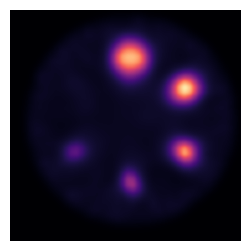

In [23]:
plt.figure(figsize=(3,3))
plt.imshow(reconstructed_image[:,:,64].cpu().T, cmap='magma', origin='lower', interpolation='Gaussian')
plt.xlim(40,85)
plt.ylim(40,85)
plt.axis('off')
plt.show()